```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data\data_230217'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [58]:
config_file = 'config_q3diamond_full688and958_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


# Qubit/resonator to probe

In [497]:
qubit_i = 1

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [60]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [261]:
im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

In [265]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [262]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# RFSoC Calibration

In [296]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=0.9,
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.8, 2408.2], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 21672, 8131, 22760], 'sigma': [0.03099, 0.01781, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21703, 0, 21713, 24537], 'sigma': [0.01776, 0, 0.01

  0%|          | 0/500 [00:00<?, ?it/s]

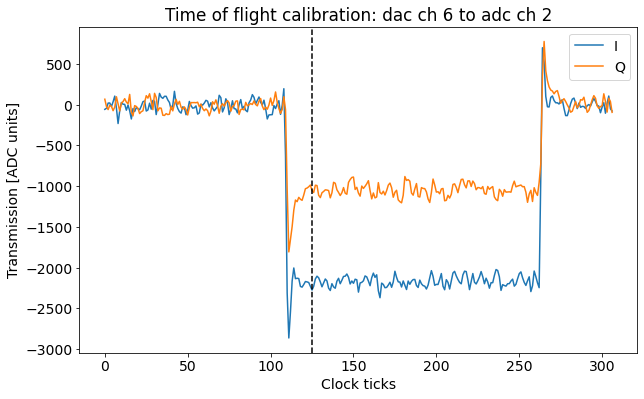

In [297]:
tof.display(adc_trig_offset=125)

In [346]:
tof.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_adc_trig_offset_calibration_qubit2.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [191]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = 3.0 # MHz
npts = 150
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=500, # Number averages per point
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

rspec.cfg.device.readout.gain = 0.95

# rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
# rspec.cfg.device.readout.readout_length = 1
print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2019, 2408.2], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 21672, 23287, 22760], 'sigma': [0.03099, 0.01781, 0.01679, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21703, 0, 21713, 24537], 'sigma': [0.01776, 0, 0.

  0%|          | 0/150 [00:00<?, ?it/s]

[819.7147, 5000, 1000, 0, 50.60648326663744, 42.348456517236045, -4.833946007897687]

Freq with minimum transmission: 820.5246999999999
Freq with maximum transmission: 818.7247
From fit:
	f0: 7694.7147
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 9.23365764
	phi [radians]: 0


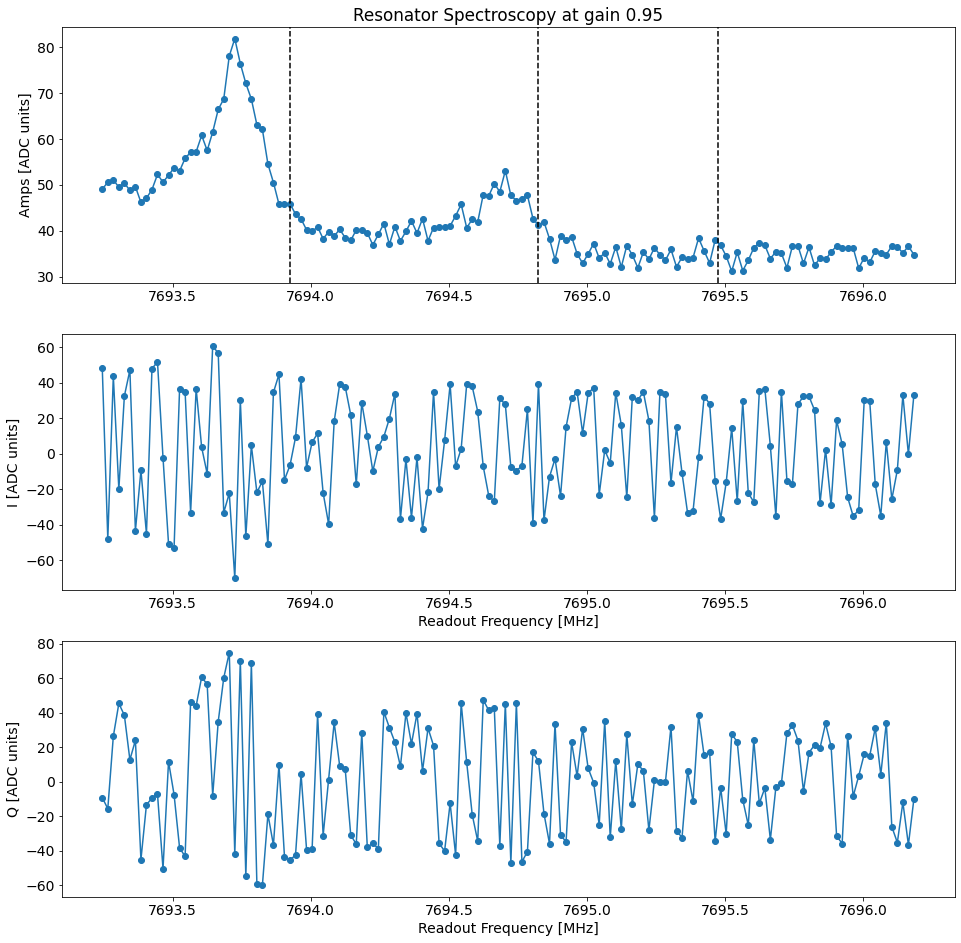

In [192]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=False, findpeaks=False)

In [136]:
rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_ResonatorSpectroscopy.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [148]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 3.0
npts_f = 101

span_gain = 0.9
npts_gain = 9

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=0.05,
    step_gain=span_gain/npts_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=600, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2019, 2408.2], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 21672, 23287, 22760], 'sigma': [0.03099, 0.01781, 0.01679, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21703, 0, 21713, 24537], 'sigma': [0.01776, 0, 0.

  0%|          | 0/10 [00:00<?, ?it/s]

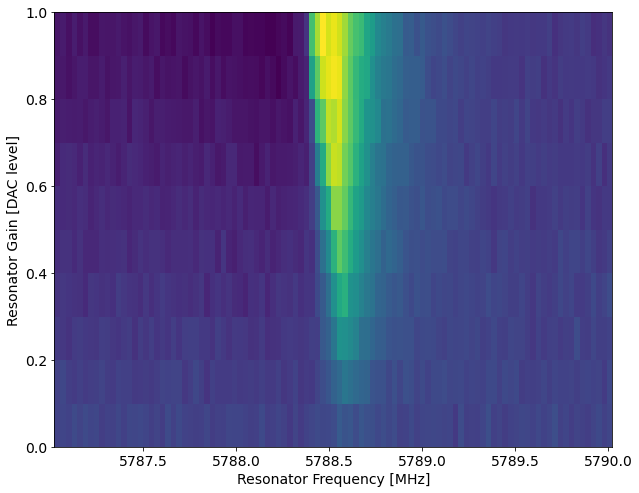

In [149]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [ ]:
rpowspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_power_sweep_resonator_spectroscopy_qubit3.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [501]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2
npts = 150

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.95*span, # resonator frequency to be mixed up [MHz]
    # start=3440,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=300, # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
# qspec.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency = -813.508 # Wait time between experiments [us]
# qspec.cfg.device.readout.gain = 0.95

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.7994265949183, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22517, 8131, 22760], 'sigma': [0.03157, 0.04, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761,

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3463.7444670089358, HWHM 0.17630569948917177
Found peak in I at [MHz] 3463.7458058218895, HWHM 0.17579214915406174
Found peak in Q at [MHz] 3463.7375508601936, HWHM 0.1794065524959357


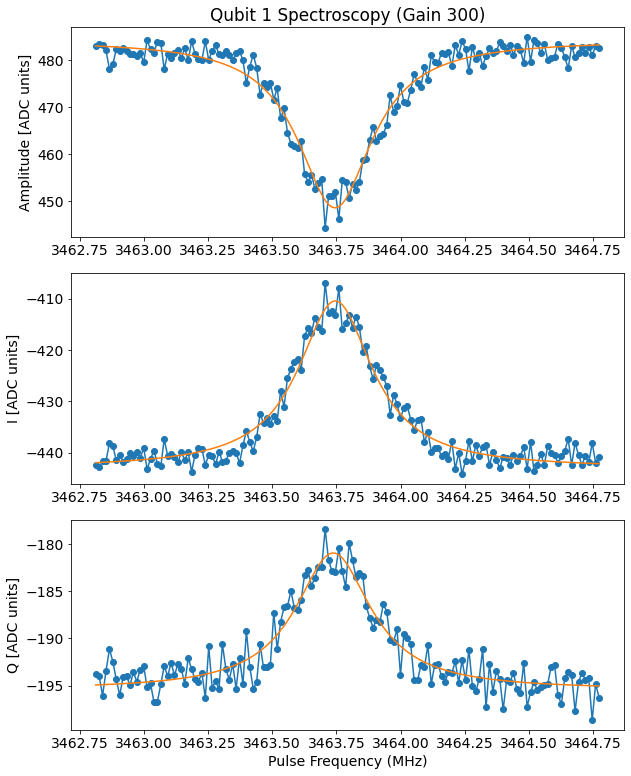

In [502]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00004_qubit_spectroscopy_qubit3.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [58]:
soc.cycles2us(20)

0.05714342857714291

In [370]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=51,
    reps=2000,
    gain=20000, # qubit gain [DAC units],
    # gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[0,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.728373773443, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 7596, 8131, 22760], 'sigma': [0.03157, 0.05, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761, 0

  0%|          | 0/51 [00:00<?, ?it/s]

Decay from avgi [us] 0.39133663390067913
Pi length from avgi data [us]: 0.04329784600767689
	Pi/2 length from avgi data [us]: 0.021648923003838444

Decay from avgq [us] 0.38513613129241253
Pi length from avgq data [us]: 0.043246211808878214
Pi/2 length from avgq data [us]: 0.021623105904439107


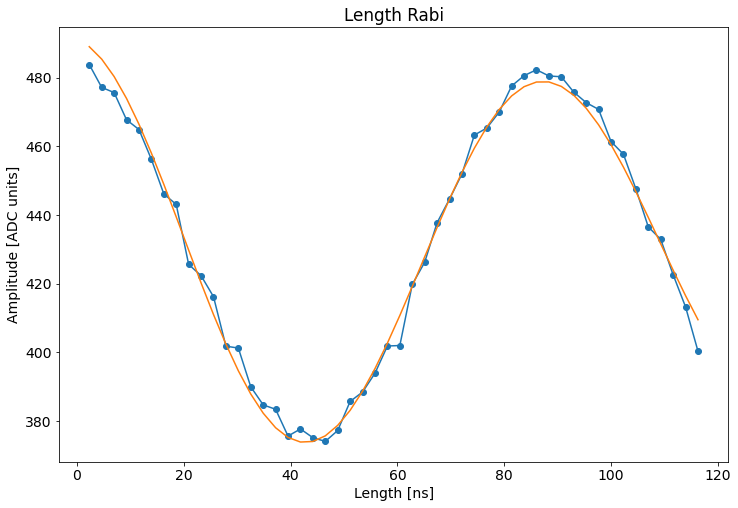

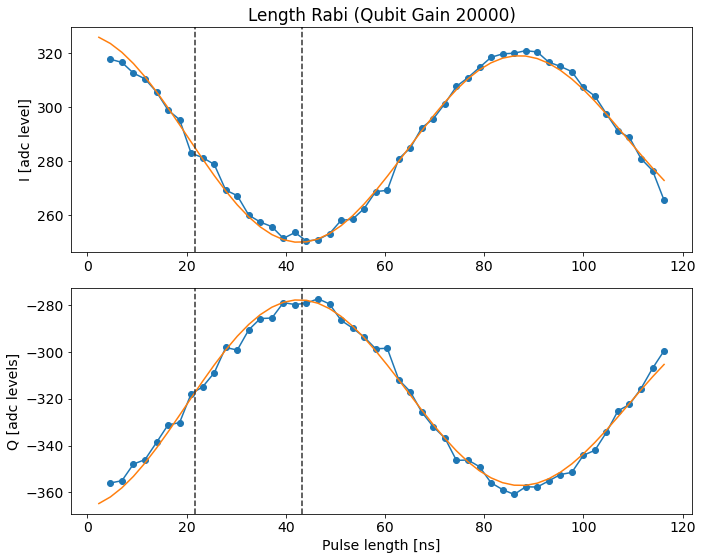

In [371]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [141]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_length_rabi_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00001_length_rabi_qubit3.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

In [503]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
# span=6000
npts = 101
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.050, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    # qubits=[0, 1],
    qubits=[qubit_i],
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.7994265949183, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22517, 8131, 22760], 'sigma': [0.03157, 0.04, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761,

  0%|          | 0/10 [00:00<?, ?it/s]

22752
Attempted to init fitparam 4 to -380.5076232208215, which is out of bounds -194.12394916632778 to -145.89510858072387. Instead init to -170.00952887352582
Attempted to init fitparam 4 to -170.00952887352582, which is out of bounds 369.0696637271739 to 481.55867468241183. Instead init to 425.31416920479285
Pi gain from avgi data [dac units]: 22308
	Pi/2 gain from avgi data [dac units]: 11154
Pi gain from avgq data [dac units]: 22776
	Pi/2 gain from avgq data [dac units]: 11388


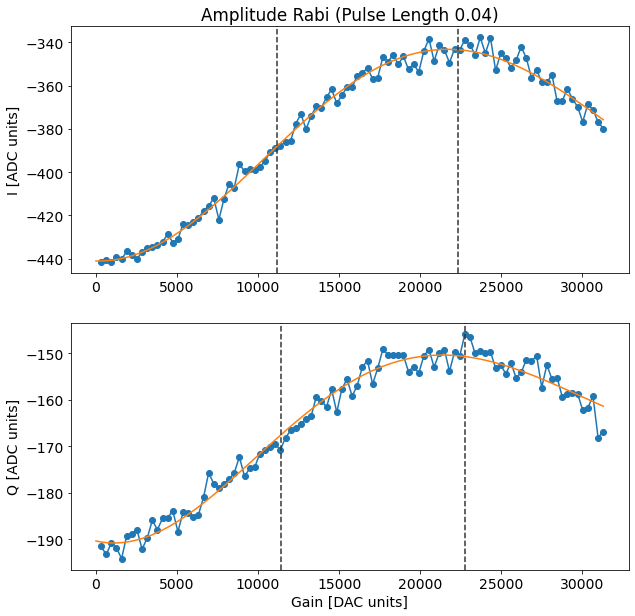

In [504]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [271]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

span_gain = 32000
npts_gain = 71

span_f = 10
npts_f = 15

amprabichev.cfg.expt = dict(
    # start_f=amprabichev.cfg.device.qubit.f_ge[0]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    start_gain=0, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [140.533743739655, -536.272, 800.1199711068375, 415.307783242773], 'f_Q1_ZZ': [3458.5532077647345, 0, 3462.6479880140837, 3462.424516152739], 'f_ef': [-85.24298, 636.6016, 610.7977211230145, 243.1626645869358], 'f_EgGf': [2678.5, 0, 2020.1, 2394.5], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [23010, 19297, 22631, 25187], 'sigma': [0.02578, 0.025, 0.02291, 0.01506], 'type': 'gauss'}, 'pi_ef': {'gain': [24185, 11000, 21496, 24157], 'sigma': [0.02354, 0.02673, 0.01816, 0.01912], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25490, 0, 24057, 21583], 'sigma': [0.015, 0, 0.015, 0.015], 'type': 'gauss'}

  0%|          | 0/15 [00:00<?, ?it/s]

24061
24088
24115
24143
24170
24197
24224
24251
24279
24306
24333
24360
24388
24415
24442


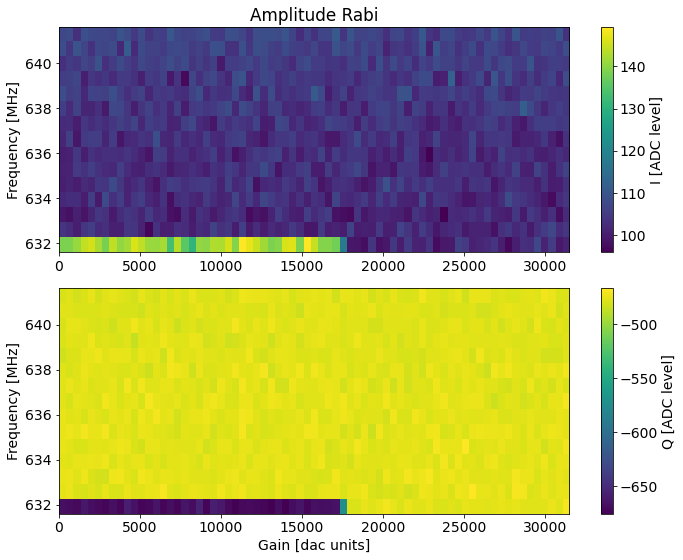

In [272]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [305]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_f=True,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=-813.408 + 0.05
# shot.cfg.device.readout.gain=0.95
# shot.cfg.device.readout.readout_length = 30 # [us]
# shot.cfg.device.readout.relax_delay = 1000 # Wait time between experiments [us]

shot.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Unrotated:
Ig 294.006100040667 +/- 52.57366943269583 	 Qg 372.65107767385115 +/- 53.88179644579971 	 Amp g 474.6666330727338
Ie 230.91114274095162 +/- 58.394141225236716 	 Qe 281.20089467263114 +/- 65.18032479363843 	 Amp e 363.859724353521
If 228.88999593330624 +/- 56.22659022465164 	 Qf 263.34363562423755 +/- 63.509568958629075 	 Amp f 348.9133139651454
Rotated:
Ig -470.3841908171944 +/- 52.57366943269583 	 Qg 61.194338795667065 +/- 53.88179644579971 	 Amp g 474.34800945232774
Ie -356.5880469940529 +/- 58.394141225236716 	 Qe 53.29931878561737 +/- 65.18032479363843 	 Amp e 360.5493761498468
If -341.69612998928056 +/- 56.22659022465164 	 Qf 60.66447188686125 +/- 63.509568958629075 	 Amp f 347.039512734448


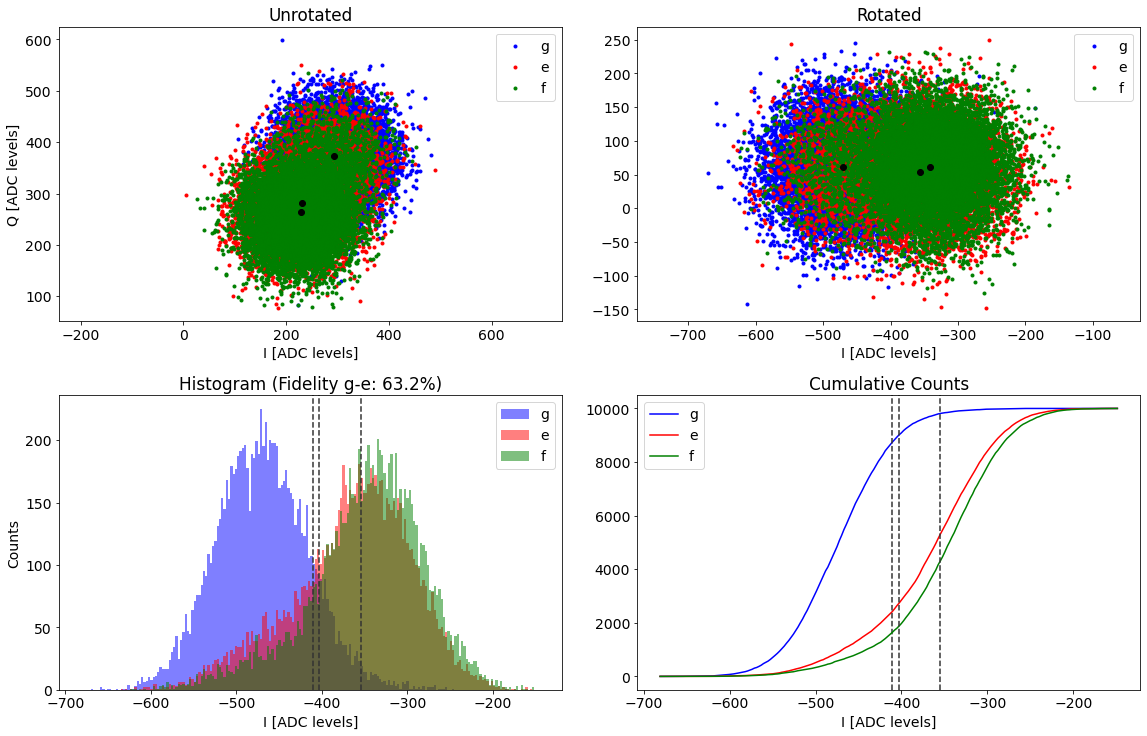

ge fidelity (%): 63.2131606580329
gf fidelity (%): 71.34713471347135
ef fidelity (%): 9.991498724808721
rotation angle (deg): 120.78289960968506
threshold ge: -410.81209041890355
threshold gf: -402.7900049587431
threshold ef: -354.65749219778036


In [306]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=False)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [126]:
shot.save_data()

Single shot drift

In [390]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 10*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

 45%|████▌     | 9/20 [10:56<13:22, 72.95s/it]


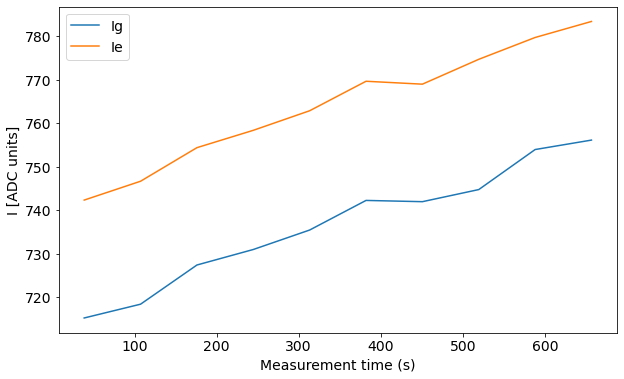

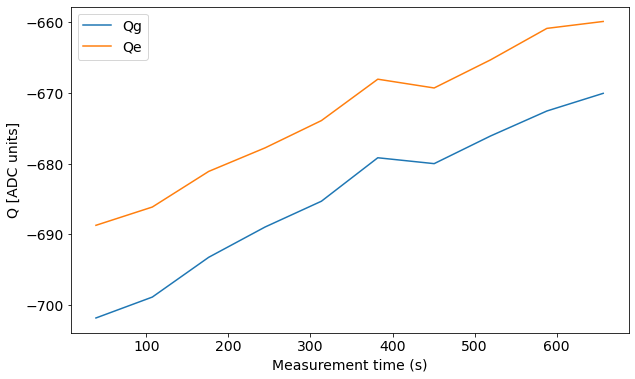

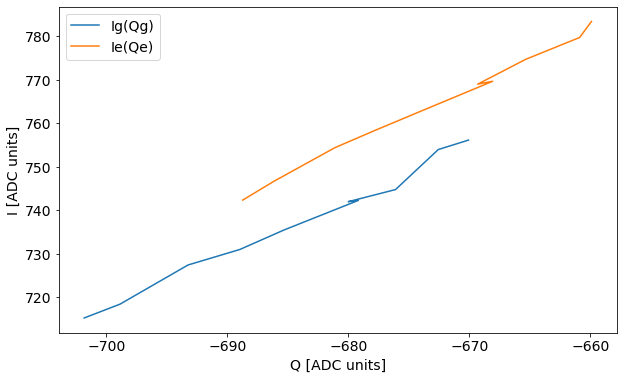

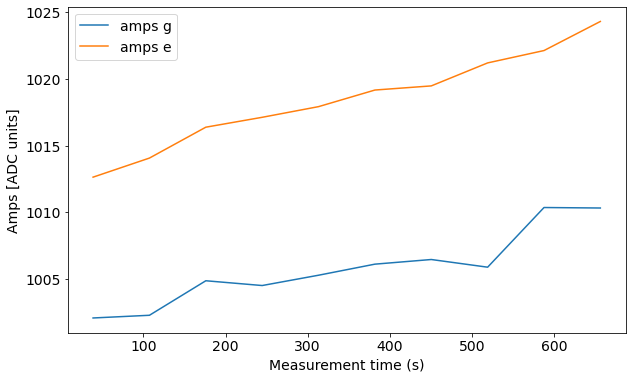

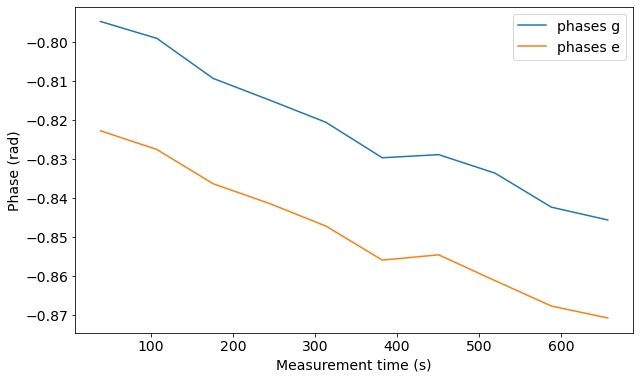

In [391]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [57]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1 # MHz
npts_f = 5

span_gain = 0.07
# npts_gain = 2
npts_gain = 7

span_len = 9 # us
# npts_len = 2
npts_len = 3

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.0555447534924, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 126.826, 0], 'threshold_ge': [0, 0, 5.5435, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'i

  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
shotopt.analyze()
print(shotopt.data['fid'])

(4, 6, 2)
[-805.55554475 -805.35554475 -805.15554475 -804.95554475 -804.75554475]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07]
[3. 6. 9.]
Max fidelity 0.14115141151411514
Set params: 
 angle (deg) 79.27975364474388 
 threshold -74.77681231100001 
 freq [Mhz] -804.7555447534925 
 gain [dac units] 0.06999999999999999 
 readout length [us] 9.0
[[[0.00840008 0.01332007 0.00761008]
  [0.0196801  0.0201102  0.02307012]
  [0.03011015 0.02903029 0.02637013]
  [0.03112016 0.03297016 0.03285016]
  [0.03341017 0.03753019 0.04184021]
  [0.03855039 0.03842019 0.03890039]
  [0.04129021 0.04111021 0.03618018]]

 [[0.03064015 0.03299016 0.03118016]
  [0.03923039 0.04150042 0.04435044]
  [0.04181042 0.04555023 0.04756024]
  [0.04568023 0.05172026 0.04778024]
  [0.05450027 0.06252031 0.05771087]
  [0.0604203  0.05873059 0.06262031]
  [0.06284031 0.05775029 0.06450032]]

 [[0.04171021 0.04239021 0.04251021]
  [0.07371074 0.08122081 0.08335083]
  [0.06460032 0.06747034 0.06370032]
  [0.05880029 0.05490027 0.05565

In [59]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [344]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 600
npts = 100

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22226, 7596, 8131, 22760], 'sigma': [0.03099, 0.05, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761,

  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 avgi [us]: 152.61855309514465
Fit T1 avgq [us]: 146.44010867953662


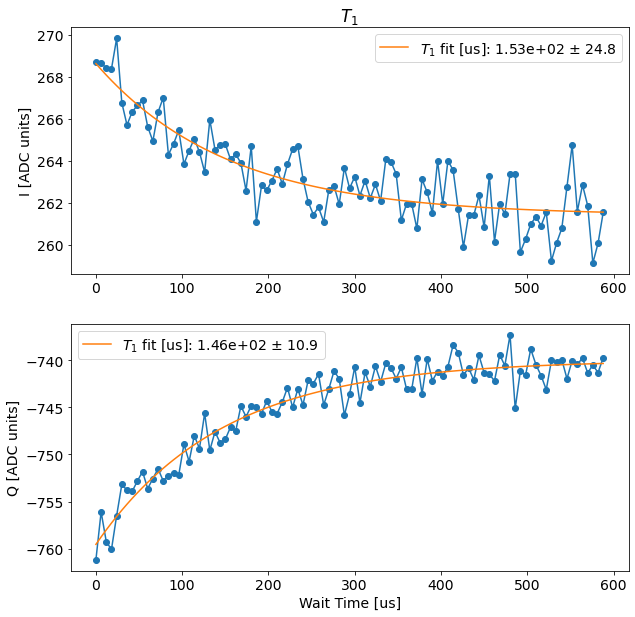

In [345]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [382]:
t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_t1_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00001_t1_qubit3.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [184]:
0.5/soc.cycles2us(50)

4.3008

In [505]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=250,
    ramsey_freq=0.5, # [MHz]
    reps=100,
    rounds=12,
    qubits=[qubit_i],
    # qubits=[1],
    # qubits=[0, 1],
    checkZZ=False,
    checkEF=False,
)
t2r.cfg.device.readout.gain = 0.15
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.7994265949183, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22776, 8131, 22760], 'sigma': [0.03157, 0.04, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761,

  0%|          | 0/12 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 4.102168674698795, which is out of bounds 0.004335483870967743 to 0.6503225806451614. Instead init to 0.32732903225806453
Current pi pulse frequency: 3463.7994265949183
Fit frequency from I [MHz]: 0.47050727627876887 +/- 0.001232044113785794
Suggested new pi pulse frequency from fit I [MHz]:
 	3463.8289193186397
 	3462.8289193186397
Beating frequency from fit I [MHz]:
 	3464.1997134573367
 	3462.30321087087
T2 Ramsey from fit I [us]: 31.271281409911104
Fit frequency from Q [MHz]: 0.4757344660819869 +/- 0.0013540077132106725
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3463.8236921288362
 	3462.8236921288362
Beating frequency from fit Q [MHz]:
 	3464.2065658416104
 	3462.340895824741
T2 Ramsey from fit Q [us]: 22.358545198758893


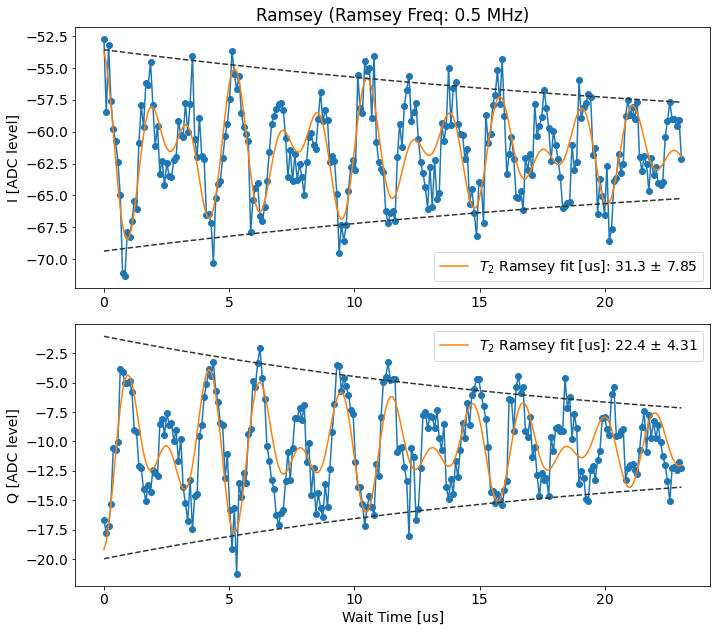

In [506]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_twofreq=True)
t2r.display(fit=True, fit_twofreq=True)

In [ ]:
rho = qt.Qobj(inpt=rho_MLE_ZZ, dims=id2q.dims, shape=id2q.shape)
rho = rho.ptrace(1)
print(rho)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.03765713+0.j      -0.15837809-0.01356j]
 [-0.15837809+0.01356j  0.96234287+0.j     ]]


In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00002_ramsey_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00002_ramsey_qubit0.h5'

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [378]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(100), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=0.100, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.728373773443, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22517, 8131, 22760], 'sigma': [0.03157, 0.04, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761, 

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.00704, which is out of bounds 0.002886442953020134 to 0.43296644295302006. Instead init to 0.2179264429530201
Current qubit frequency: 3463.728373773443
Fit frequency from I [MHz]: 0.22334582131850103 +/- 0.014555161964892746
T2 Echo from fit I [us]: 10.39341517857143
Fit frequency from Q [MHz]: 0.09997213440084908 +/- 0.0001333900510454676
T2 Echo from fit Q [us]: 57.99403098484363


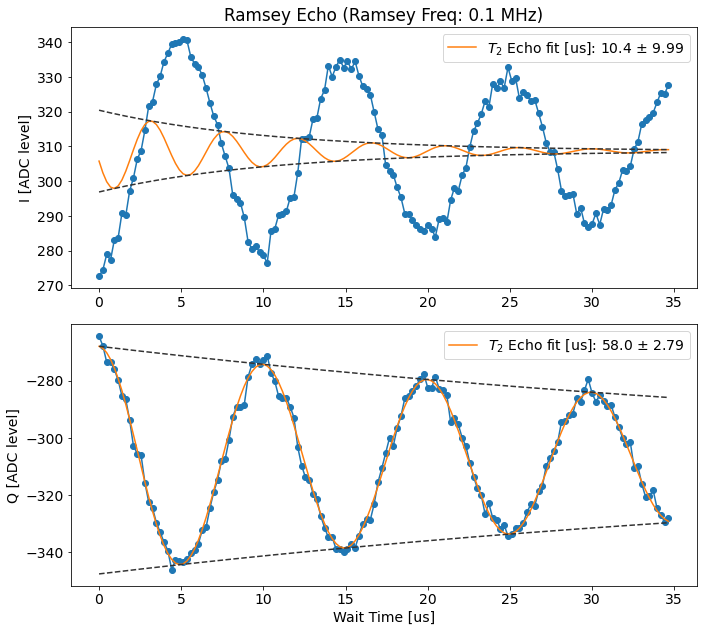

In [379]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [168]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 10
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3435,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=50, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=100, # ef pulse gain
    qubit=qubit_i,
)

qEFspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.7059861124717, 3463.808810074577, 3462.8644013091084, 3462.7481140969167], 'f_ef': [3914.7570214638718, 3363.522849557666, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.75, 0, 2024.35, 2409.45], 'gs': [56.41030563, 74.31933724, 50.37948286, 19.70297012, 5.79175295, 10.44168119], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [23010, 22828, 22631, 25187], 'sigma': [0.02578, 0.015, 0.02291, 0.01506], 'type': 'gauss'}, 'pi_ef': {'gain': [24185, 23074, 21496, 24157], 'sigma': [0.02354, 0.02673, 0.01816, 0.01912], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21984, 0, 22637, 1245

  0%|          | 0/50 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3363.5351642423757, HWHM 0.5044099753121568
Found peak in I at [MHz] 3363.528055039919, HWHM 0.505879909086716
Found peak in Q at [MHz] 3363.4224498327194, HWHM 0.5919028532673675


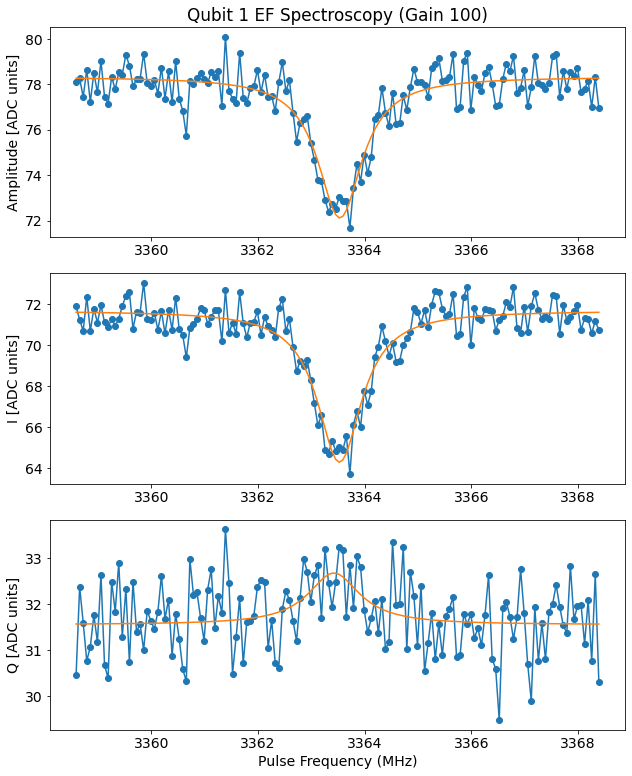

In [169]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [210]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_EF_spectroscopy_qubit3.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [234]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=10000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.5552505231310596
Pi length from avgi data [us]: 0.025127474845967727
	Pi/2 length from avgi data [us]: 0.012563737422983863

Decay from avgq [us] 0.5532629539556512
Pi length from avgq data [us]: 0.024908733068296267
Pi/2 length from avgq data [us]: 0.012454366534148133


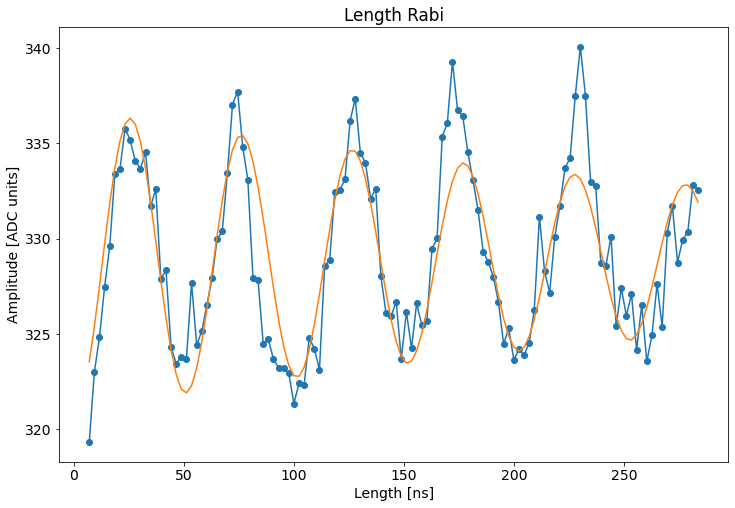

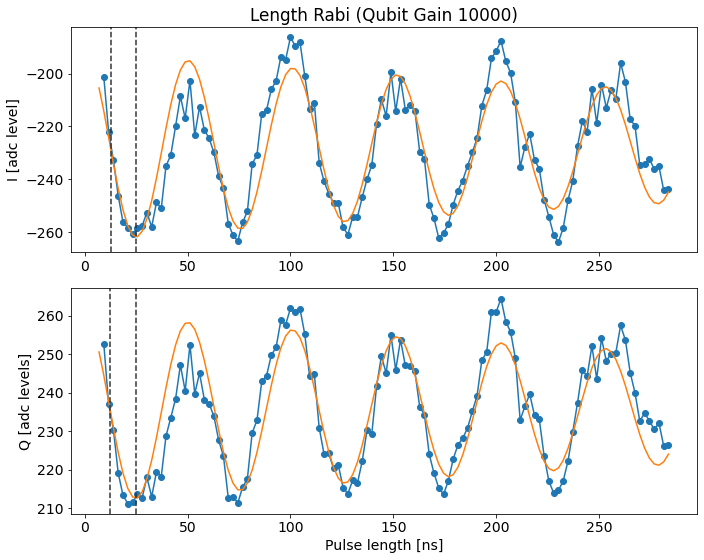

Use sigma 0.023116972127467664 for amplitude rabi EF


In [235]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

In [ ]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [495]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.0120, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=True, # set to false when measuring qubit temp
    checkEF=True,
    checkZZ=False,
    pulse_type='gauss',
    qubits=[qubit_i],
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.7994265949183, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22517, 8131, 22760], 'sigma': [0.03157, 0.04, 0.07, 0.01824], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 0, 0.01761,

  0%|          | 0/30 [00:00<?, ?it/s]

22919
Attempted to init fitparam 4 to -1014.0754886235966, which is out of bounds -450.1741843567845 to -445.7320570692694. Instead init to -447.9531207130269
Attempted to init fitparam 4 to -447.9531207130269, which is out of bounds 1106.846826816489 to 1110.3752457677344. Instead init to 1108.6110362921117
Pi gain from avgi data [dac units]: 8493
	Pi/2 gain from avgi data [dac units]: 4246
Pi gain from avgq data [dac units]: 189230
	Pi/2 gain from avgq data [dac units]: 94615


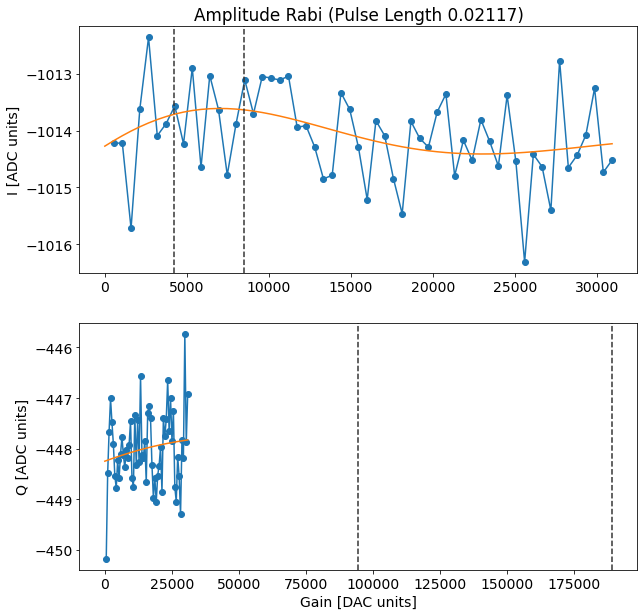

In [496]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [346]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_amp_rabi_EF_qubit0.h5


### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [494]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

print(amprabiEF.data.keys())
amps = amprabiEF.data['amps']

print(np.max(amps) - np.min(amps))
efamp_normal = 86.51557376731512
efamp_nopulse = 2

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


dict_keys(['xpts', 'avgi', 'avgq', 'amps', 'phases', 'fit_avgi', 'fit_avgq', 'fit_amps', 'fit_err_avgi', 'fit_err_avgq', 'fit_err_amps'])
7.337847727106691
Qubit temp [mK]: 52.74880858154913


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [232]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(30), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=150,
    ramsey_freq=0.500, # [MHz]
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 65, 50, 150], 'f_ge': [4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773], 'f_Q1_ZZ': [3458.5532077647345, 0, 3462.6479880140837, 3462.424516152739], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2678.5, 0, 2020.1, 2394.5], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [23010, 22828, 22631, 25187], 'sigma': [0.02578, 0.015, 0.02291, 0.01506], 'type': 'gauss'}, 'pi_ef': {'gain': [24185, 11000, 21496, 24157], 'sigma': [0.02354, 0.02673, 0.01816, 0.01912], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25490, 0, 24057, 21583], 'sigma': [0.015, 0,

  0%|          | 0/10 [00:00<?, ?it/s]

Current EF frequency: 3363.398427976613
Fit frequency from I [MHz]: 0.18286979499967768
Suggested new EF frequencies from fit avgi [MHz]:
 	3363.7155581816137
 	3362.7155581816137
T2 Ramsey EF from fit avgi [us]: 3.097098214285715
Fit frequency from Q [MHz]: 0.20203246038440412
Suggested new EF frequencies from fit avgq [MHz]:
 	3363.6963955162287
 	3362.6963955162287
T2 Ramsey EF from fit avgq [us]: 3.097098214285715


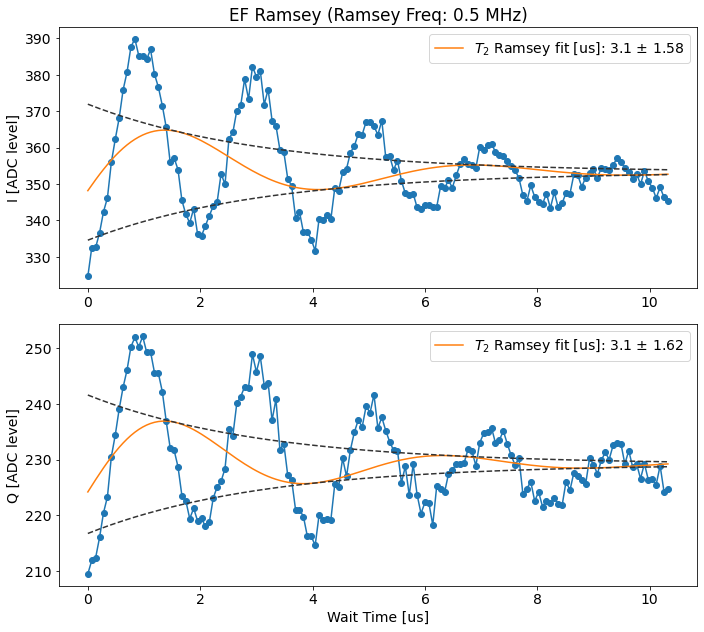

In [233]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [363]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramseyEF_qubit0.h5


# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [28]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 50
npts_f = 150

span_gain = 30000
npts_gain = 5

pump_params=dict(
    ch=4,
    type='full',
    nyquist=1,
)

acspec.cfg.expt = dict(
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=1, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=12, # [us]
    qubit_gain=800,
    qubit_length=10, # [us]
    reps=1000,
    rounds=20, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 10
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4

  0%|          | 0/5 [00:00<?, ?it/s]

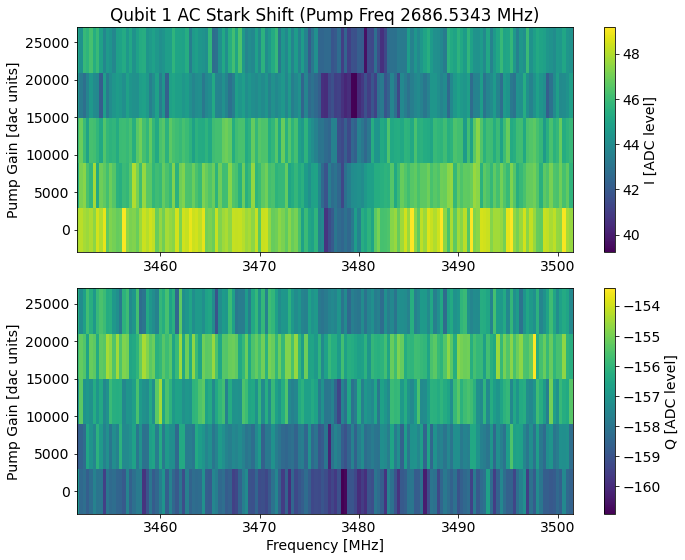

In [29]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

In [30]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_ac_stark_shift_qubit1.h5


# Single qubit RB

{'device': {'qubit': {'T1': [97, 53, 46, 58], 'f_ge': [823.0681204610527, 3473.31, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2434148826505, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 23585, 22539, 28755], 'sigma': [0.0386, 0.0217, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 15332, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -808.35, -79.784, 81.64542225717739], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.92, 0.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Qubit  (0)


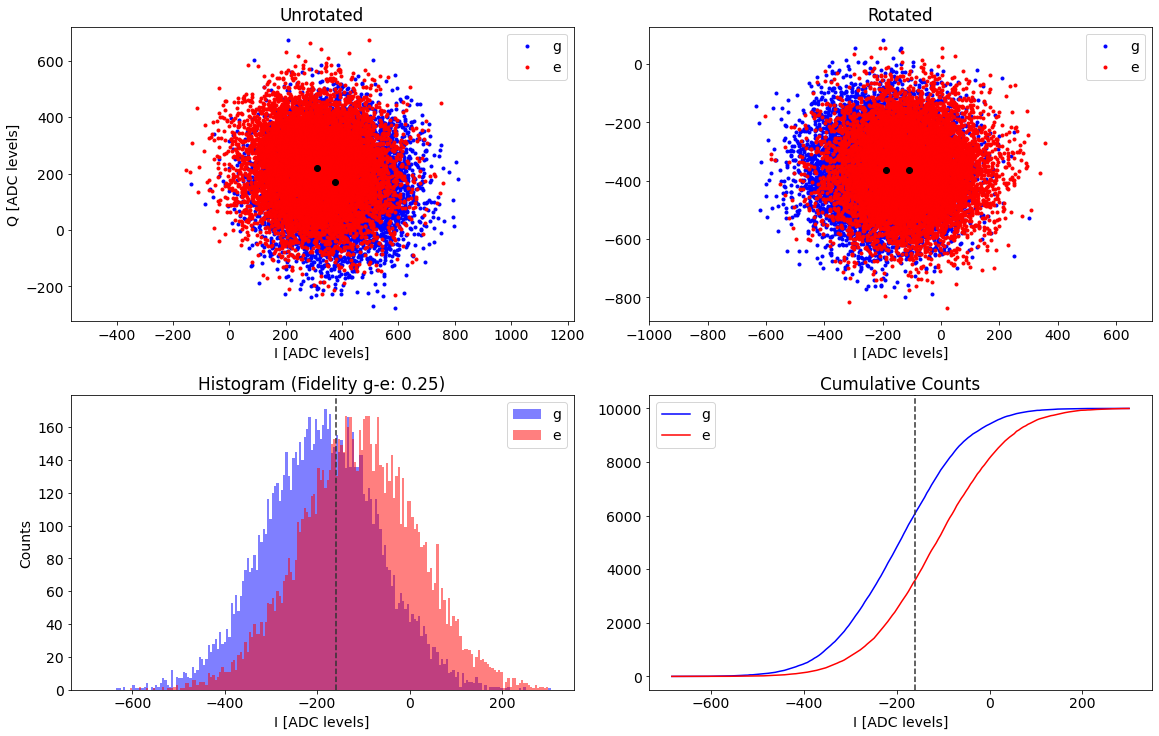

ge fidelity (%): 24.973746061909285 	 angle (deg): -142.06360567273813 	 threshold ge: -159.76791430708363
angles=[-142.06360567273813, 0, 0, 0]
thresholds=[-159.76791430708363, 0, 0, 0]
ge_avgs=[[373.5939400260332, 169.76653198828507, 310.40417552879916, 219.37187510575987], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]


  0%|          | 0/15 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:330: RuntimeWarning: divide by zero encountered in true_divide
  avgi /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]
s:\Connie\experiments\qramLL_4QR2\experiments\clifford_averager_program.py:331: RuntimeWarning: divide by zero encountered in true_divide
  avgi_err /= ge_avgs_rot[:,1] - ge_avgs_rot[:,0]


In [142]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=10, # step rb depth
    expts=15, # number steps
    reps=7000, # number averages per unique sequence
    variations=30, # number different sequences per depth
    # gate_char='X', # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=True, # specifies whether to run RB treating EgGf as the TLS subspace
    qubits=[qubit_i], # the qubits to perform simultaneous RB on
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    # angles=[0, 46.170750588583914, 0, 0],
    # thresholds=[0, 1313.2273024770407, 0, 0],
    # ge_avgs=[[0,0,0,0], [1202.93042968, -519.547555,   1357.15032001, -679.76484953],[0,0,0,0], [0,0,0,0]]
)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

Running regular RB on EgGf subspace
**Depolarizing parameter p: 0.989783402436281
Average RB error: 0.005108298781859477
so average RB fidelity: 0.9948917012181405


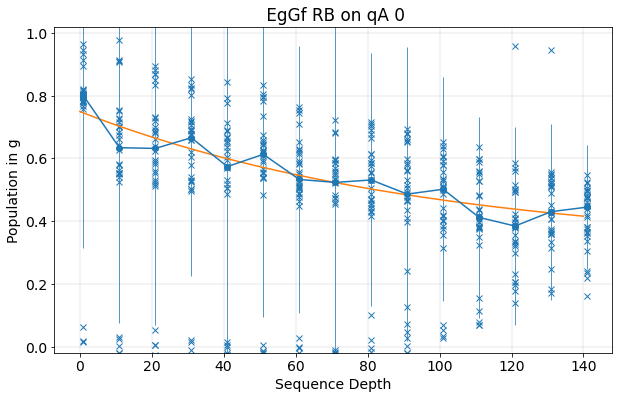

In [143]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=qubit_i)

In [146]:
meas.fitting.rb_gate_fidelity(p_rb=0.989783402436281, p_irb=0.920144, d=2)

0.96482088795141

In [144]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00001_rb1Q_qubit0.h5


In [154]:
class Clifford():
    def xpulse(self):
        print('normal clifford')

    def ypulse(self):
        print('y')
        self.xpulse()

class CliffordEF(Clifford):
    def xefpulse(self):
        print('ef')

class CliffordEgGf(CliffordEF):
    def xpulse(self):
        super().xpulse()
        print('EgGf')

class SimRB(Clifford):
    def clifford(self, flag=None):
        if flag == 'X': self.xpulse()
        elif flag == 'Y': self.ypulse()
    
class RBEgGf(CliffordEgGf, SimRB):
    pass

rbeggf = RBEgGf()
print(RBEgGf.__mro__)
rbeggf.clifford(flag='X')
rbeggf.clifford(flag='Y')

(<class '__main__.RBEgGf'>, <class '__main__.CliffordEgGf'>, <class '__main__.CliffordEF'>, <class '__main__.SimRB'>, <class '__main__.Clifford'>, <class 'object'>)
normal clifford
EgGf
y
normal clifford
EgGf
